In [24]:
from data_processing import Dataset
from noise import NoiseScheduler
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from torchvision import transforms
import torch
import random
random.seed(10)
print(random.random())

0.5714025946899135


In [2]:
if(torch.backends.cuda.is_built()) : 
    device='cuda'
elif(torch.backends.mps.is_built()) : 
    device='mps'
else : 
    device='cpu'

In [3]:
data_dir = "/cephfs/dice/projects/L1T/diffusion/datasets/"       # set to directory where data is stored

dataset = Dataset(1_000, (120, 72), signal_file=f"{data_dir}/CaloImages_signal.root", pile_up_file=f"{data_dir}/CaloImages_bkg.root", save=False)

In [4]:
dataset() #once this is cached, you don't have to re-load

INFO:root:loading file /cephfs/dice/projects/L1T/diffusion/datasets//CaloImages_signal.root
loading file /cephfs/dice/projects/L1T/diffusion/datasets//CaloImages_signal.root
100%|██████████| 1000/1000 [00:01<00:00, 922.41it/s]
INFO:root:loading file /cephfs/dice/projects/L1T/diffusion/datasets//CaloImages_bkg.root
loading file /cephfs/dice/projects/L1T/diffusion/datasets//CaloImages_bkg.root
100%|██████████| 1000/1000 [00:01<00:00, 915.79it/s]


In [5]:
new_dim=(64,64)

In [6]:
dataset.preprocess(16, new_dim)     # ensure these have the same values as when the model was trained

INFO:root:scaling
scaling


INFO:root:re-sizing
re-sizing


In [7]:
preprocess = transforms.Compose(
        [
            transforms.ToTensor()
        ]
)

MOVING DATA TO GPU

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [9]:
# Added .to(device) to move data to GPU
clean_frames = preprocess(dataset.signal).float().permute(1, 2, 0).unsqueeze(1).to(device) #pytorch symantics
pile_up = preprocess(dataset.pile_up).float().permute(1, 2, 0).unsqueeze(1).to(device)

In [10]:
### Select one image to perform inference on
i = 10      # image 
noise_scheduler = NoiseScheduler('pile-up')

# Each unit of timestep represents an addtional 5 pile-up events (max 40 = 200PU)
timestep = torch.LongTensor([40]).to(device)   # Added .to(device) to move data to GPU
random_seed = 42
noisy_image, noise = noise_scheduler.add_noise(clean_frame=clean_frames[i], noise_sample=pile_up, timestep=timestep, random_seed=random_seed, n_events = 1000)

Text(0.5, 1.0, 'Noised Image')

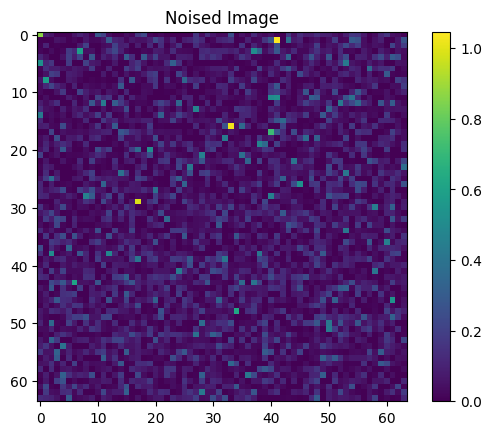

In [11]:
#plt.imshow(noisy_image.reshape(new_dim))
noisy_image = noisy_image.cpu()
plt.imshow(noisy_image.numpy().reshape(new_dim))
plt.colorbar()
plt.title("Noised Image")

In [12]:
from models import Model, UNetLite, UNetLite_hls
modtype = 'UNet_lite' # Change Model type here

if modtype == 'UNet2d':
    model = Model('UNet', new_dim)
    model = model.__getitem__()

elif modtype == 'UNet_lite':
    model = UNetLite_hls()

# Move model to GPU
model = model.to(device)    

print(model)

UNetLite_hls(
  (relu): ReLU()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (up): Upsample(scale_factor=2.0, mode='nearest')
  (emb1): Linear(in_features=4, out_features=1, bias=True)
  (convd1_1): Conv2d(1, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (normd1_1): GroupNorm(1, 2, eps=1e-05, affine=True)
  (convd1_2): Conv2d(2, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (normd1_2): GroupNorm(1, 4, eps=1e-05, affine=True)
  (emb2): Linear(in_features=4, out_features=4, bias=True)
  (convd2_1): Conv2d(4, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (normd2_1): GroupNorm(1, 6, eps=1e-05, affine=True)
  (convd2_2): Conv2d(6, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (normd2_2): GroupNorm(1, 8, eps=1e-05, affine=True)
  (emb3): Linear(in_features=4, out_features=8, bias=True)
  (convd3_1): Conv2d(8, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), b

/software/sa21722/miniconda3/envs/sd_env/lib/python3.9/site-packages/diffusers/models/transformers/transformer_2d.py:34: FutureWarning: `Transformer2DModelOutput` is deprecated and will be removed in version 1.0.0. Importing `Transformer2DModelOutput` from `diffusers.models.transformer_2d` is deprecated and this will be removed in a future version. Please use `from diffusers.models.modeling_outputs import Transformer2DModelOutput`, instead.
  deprecate("Transformer2DModelOutput", "1.0.0", deprecation_message)


In [13]:
#if modtype == 'UNet2d':
#    model = model.__getitem__()


In [14]:
if modtype == 'UNet2d':
    trained_model_path = '/cephfs/dice/projects/L1T/diffusion/trained_models/trained_diffusor.pt'
elif modtype == 'UNet_lite':
    trained_model_path = 'trained_models_lite/model_epoch_9.pt' # Specify folder for which trained model here! (eg. saturation_16 etc.)

print(trained_model_path)

trained_models_lite/model_epoch_9.pt


In [15]:
#checkpoint = torch.load(trained_model_path)
checkpoint = torch.load(trained_model_path, map_location=device)  # Ensure checkpoint is loaded to the correct device

In [16]:
model.load_state_dict(checkpoint)

<All keys matched successfully>

Text(0.5, 1.0, 'Noise Prediction')

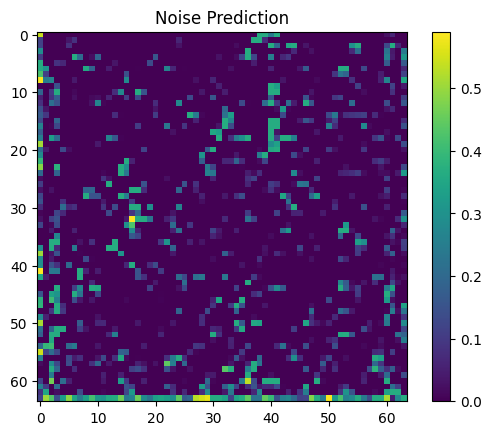

In [17]:
noisy_image = noisy_image.to(device)

if modtype == 'UNet2d':
    noise_pred = model(noisy_image.unsqueeze(1), timestep, return_dict=False)[0]
elif modtype == 'UNet_lite':
    noise_pred = model(noisy_image.unsqueeze(1), timestep)       #, return_dict=False)[0]

# Display the noise prediction
#ims = plt.imshow(noise_pred.detach().numpy().reshape(new_dim))
noise_pred = noise_pred.detach().cpu()
ims = plt.imshow(noise_pred.numpy().reshape(new_dim)) # Move prediction back to CPU for visualization
plt.colorbar(ims)
plt.title("Noise Prediction")

In [18]:
de_noised = noisy_image.cpu()[0] - (noise_pred.detach().cpu().numpy().reshape(new_dim))

Text(0.5, 1.0, 'Denoised Image')

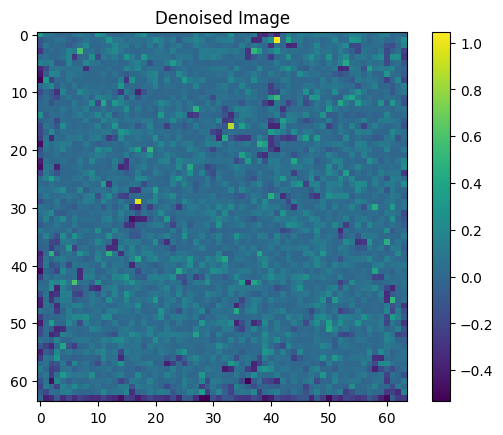

In [19]:

im = plt.imshow(de_noised.reshape(new_dim))
plt.colorbar(im)
plt.title("Denoised Image")

Text(0.5, 1.0, 'Clean Image')

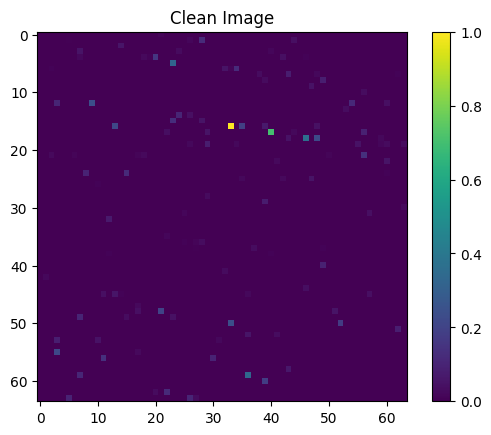

In [20]:
im2 = plt.imshow(clean_frames.cpu()[i].squeeze())
plt.colorbar(im2)
plt.title("Clean Image")

In [21]:
err = clean_frames.cpu()[i].squeeze()-de_noised.reshape(new_dim)
print(f"MSE: {np.mean((err.numpy())**2)}")


MSE: 0.016333244740962982


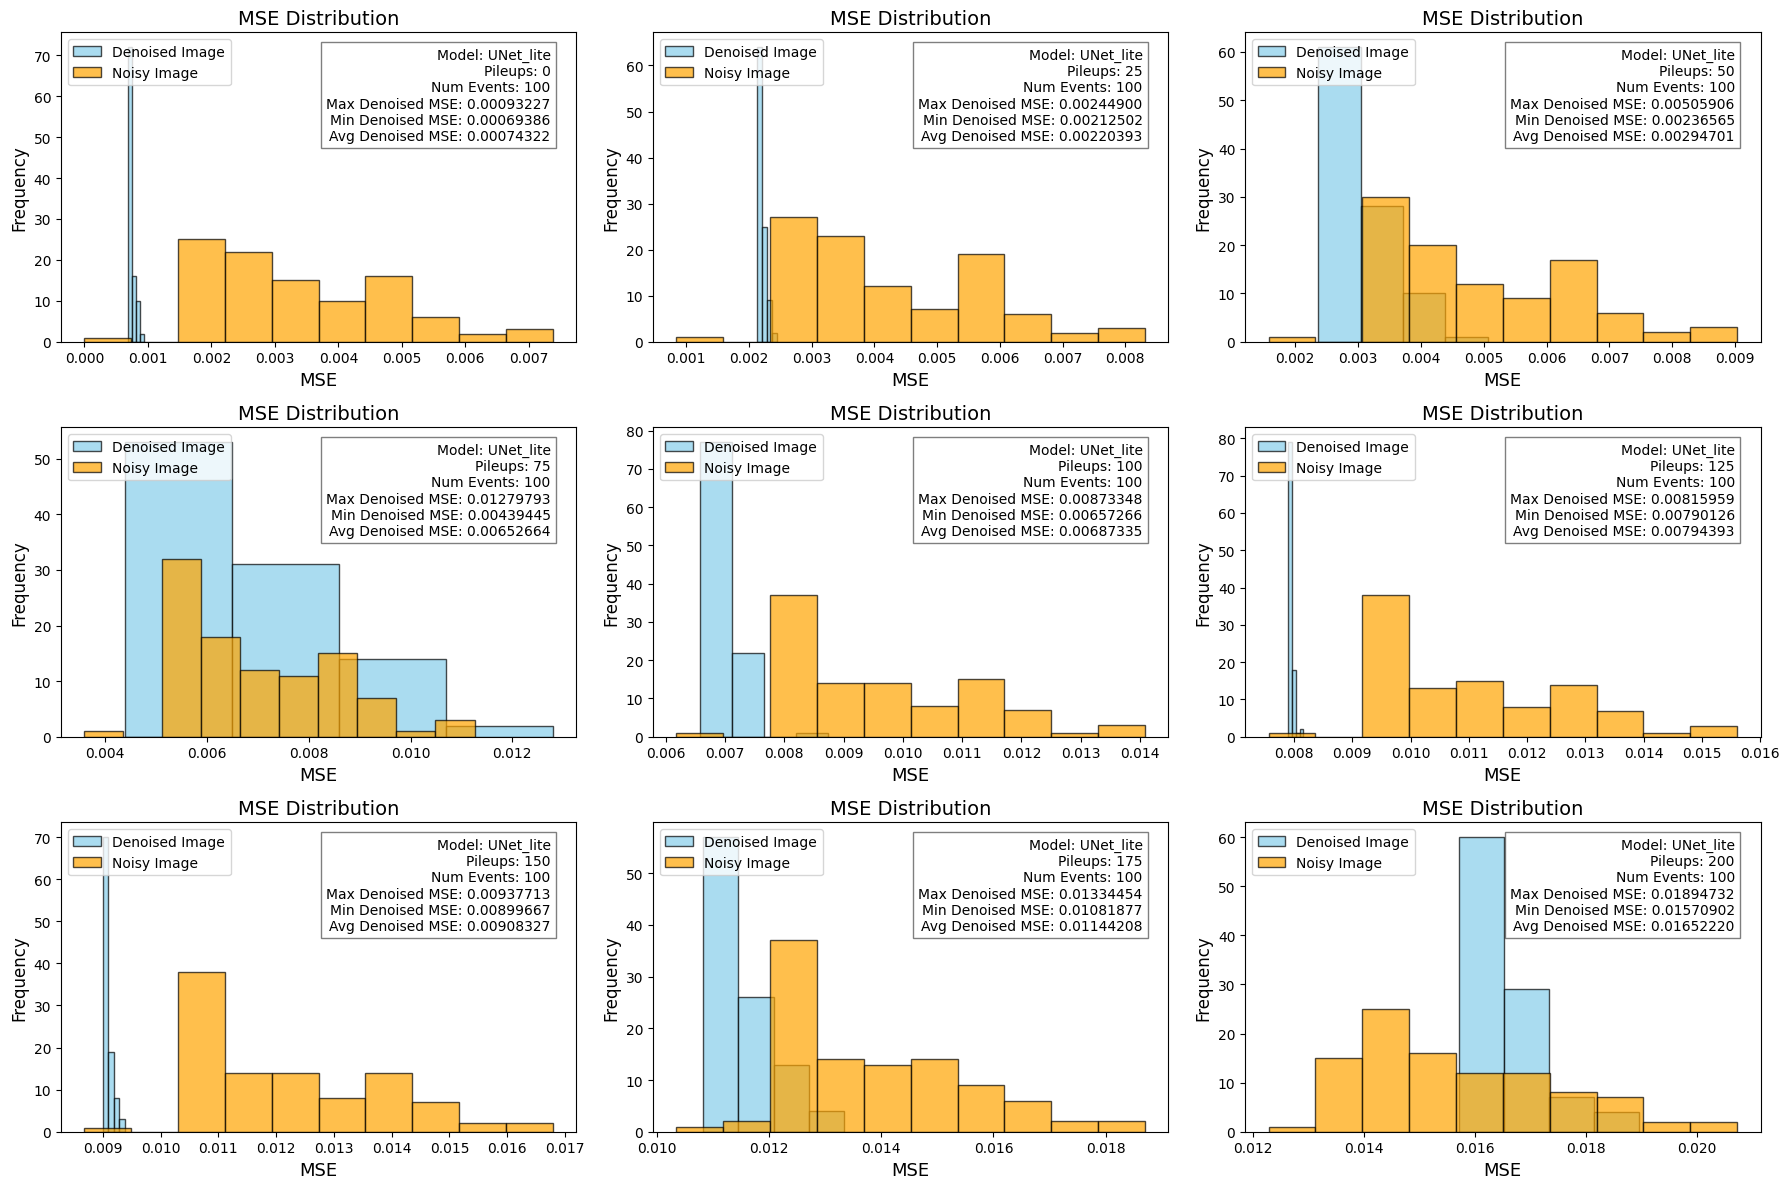

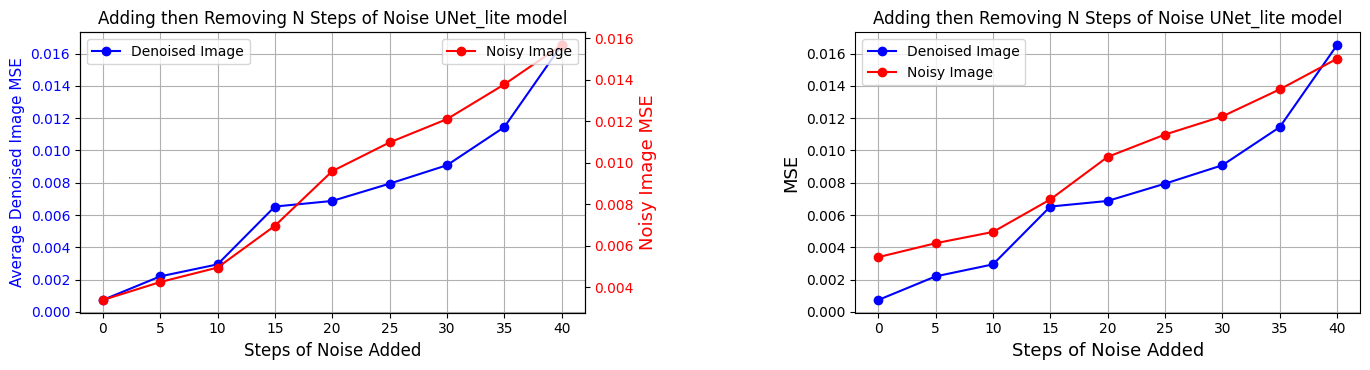

In [22]:
timesteps = [0, 5, 10, 15, 20, 25, 30, 35, 40] # Which timesteps to perform denoising at
num_events = 100 # Number of trials where denoising process is performed and evaluated
# Create arrays to hold MSEs for each event at each timestep
denoised_results = np.zeros((len(timesteps),num_events)) # For MSEs between denoised image and clean image
noisy_results = np.zeros((len(timesteps),num_events)) # For MSEs between noisy image and clean image

if len(timesteps)%3 != 0: #Add extra row if number not divisible by 3 to hold the remaining plots
    extra_row=1
else:
    extra_row=0
    

fig, axes = plt.subplots(len(timesteps)//3 + extra_row, 3, figsize=(18, 12))  # eg. 3x3 grid for 9 timesteps

#Add a specific amount of noise at each timestep
for idx, timestep_value in enumerate(timesteps): # pairs up values of timesteps (=timestep_value) with their indexes(=idx)

    # Run the denoising process a number of  times
    for event in range(num_events):
        noise_scheduler = NoiseScheduler('pile-up')
        timestep = torch.LongTensor([timestep_value])
        timestep = timestep.to(device)
        random_seed = 42

        # Create noisy image and noise prediction
        noisy_image, noise = noise_scheduler.add_noise(clean_frame=clean_frames[event], noise_sample=pile_up, timestep=timestep, random_seed=random_seed, n_events=1000)
        
        noise_pred = model(noisy_image.unsqueeze(1), timestep)[0]
        de_noised = noisy_image.cpu()[0] - (noise_pred.detach().cpu().numpy().reshape(new_dim))

        # Calc difference between denoised image and clean image
        denoised_err = clean_frames[event].squeeze().cpu() - de_noised.reshape(new_dim).cpu()
        denoised_MSE = np.mean((denoised_err.cpu().numpy())**2)
        denoised_results[idx, event] = denoised_MSE

        # Calc difference between noisy image and clean image
        noisy_err = clean_frames[0].squeeze() - noisy_image.reshape(new_dim)
        noisy_MSE = np.mean((noisy_err.cpu().numpy())**2)
        noisy_results[idx, event] = noisy_MSE
    
    av_denoised_MSE = np.mean(denoised_results, axis=1)
    av_noisy_MSE = np.mean(noisy_results, axis=1)
    
    # Plot required number of histograms
    ax = axes[idx // 3, idx % 3]  # Determine subplot position

    # Plot histogram for denoised results at each timestep
    denoised_mses_bins = np.linspace(min(denoised_results[idx]), max(denoised_results[idx]), 5)
    ax.hist(denoised_results[idx], bins=denoised_mses_bins, color='skyblue', alpha=0.7, edgecolor='black', label='Denoised Image')

    # Plot histogram for noisy results at each timestep on same plot
    noisy_mses_bins = np.linspace(min(noisy_results[idx]), max(noisy_results[idx]), 11)
    ax.hist(noisy_results[idx], bins=noisy_mses_bins, color='orange', alpha=0.7, edgecolor='black', label='Noisy Image')
    ax.set_title('MSE Distribution', fontsize=14)
    ax.set_xlabel('MSE', fontsize=13)
    ax.set_ylabel('Frequency', fontsize=12)
    ax.legend(loc='upper left')
    
    # Adding text box with statistics
    textstr = '\n'.join((
        f'Model: {modtype}',
        f'Pileups: {timestep_value*5}',
        f'Num Events: {num_events}',
        f'Max Denoised MSE: {max(denoised_results[idx]):.8f}',
        f'Min Denoised MSE: {min(denoised_results[idx]):.8f}',
        f'Avg Denoised MSE: {av_denoised_MSE[idx]:.8f}'
    ))
    ax.text(0.95, 0.95, textstr, transform=ax.transAxes, fontsize=10,
            verticalalignment='top', horizontalalignment='right',
            bbox=dict(facecolor='white', alpha=0.5))

fig.tight_layout()
plt.show()

# Calculate and plot average MSE vs. level of noise added
fig, axs = plt.subplots(1, 2, figsize=(16,6))

# Plot both on same graph with different axes
axs[0].plot(timesteps, av_denoised_MSE, marker='o', linestyle='-', color='blue', label='Denoised Image')
axs[0].set_title(f'Adding then Removing N Steps of Noise {modtype} model', fontsize=12)
axs[0].set_xlabel('Steps of Noise Added', fontsize=12)
axs[0].set_ylabel('Average Denoised Image MSE', color='blue', fontsize=11)
axs[0].tick_params(axis='y', labelcolor='blue')
axs[0].grid(True)
axs[0].legend(loc='upper left')

axs[0] = axs[0].twinx()
axs[0].plot(timesteps, av_noisy_MSE, marker='o', linestyle='-', color='red', label='Noisy Image')
axs[0].set_ylabel('Noisy Image MSE', color='red', fontsize=13)
axs[0].tick_params(axis='y', labelcolor='red')
axs[0].legend(loc='upper right')

# Plot both on same graph with same axis
axs[1].plot(timesteps, av_denoised_MSE, marker='o', linestyle='-', color='blue', label='Denoised Image')
axs[1].plot(timesteps, av_noisy_MSE, marker='o', linestyle='-', color='red', label='Noisy Image')
axs[1].set_title(f'Adding then Removing N Steps of Noise {modtype} model', fontsize=12)
axs[1].set_xlabel('Steps of Noise Added', fontsize=13)
axs[1].set_ylabel('MSE', fontsize=13)
axs[1].legend()
axs[1].grid(True)


fig.tight_layout(pad=9)  # Adjust subplots to fit into figure area.

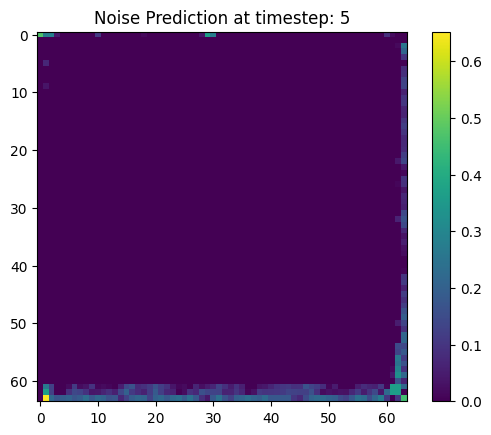

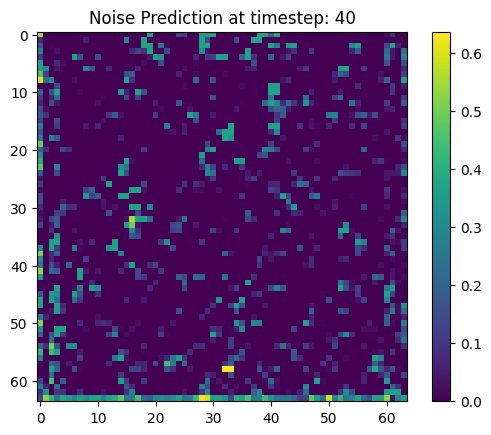

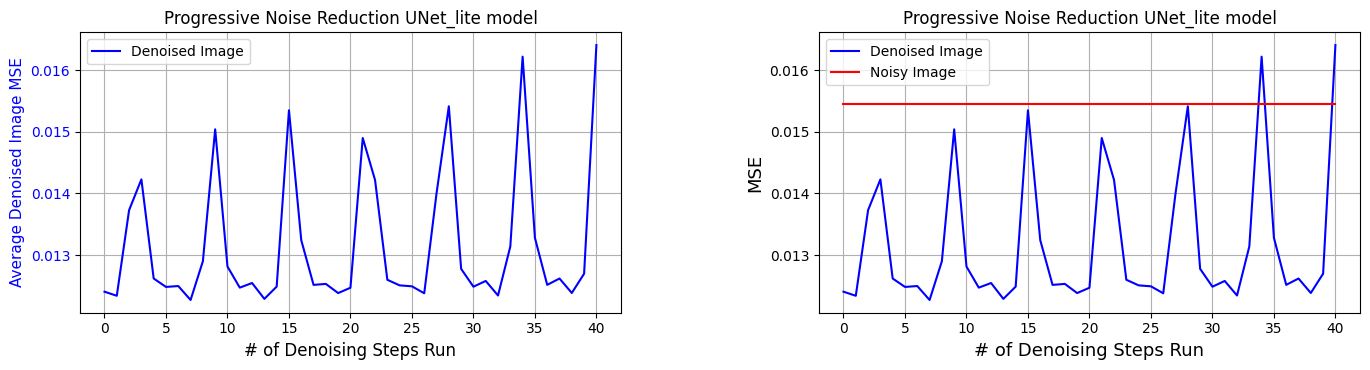

In [23]:
timesteps = np.arange(0,41,1) # Which timesteps to perform denoising at
num_events = 30 # Number of trials

# Create arrays to hold MSEs for each event at each timestep
denoised_results = np.zeros((len(timesteps),num_events)) # For MSEs between denoised image and clean image
noisy_results = np.zeros(num_events) # For MSEs between noisy image and clean image

noise_scheduler = NoiseScheduler('pile-up')
maxTimestep = torch.LongTensor([40])

for event in range(num_events):

    random_seed = 42
    

    # Generate the noisy image at maxTimestep (200 pile-ups)
    noisy_image, noise = noise_scheduler.add_noise(clean_frame=clean_frames[event], noise_sample=pile_up, timestep=maxTimestep, random_seed=random_seed, n_events=1000)
    noisy_err = clean_frames[0].squeeze() - noisy_image.reshape(new_dim)
    noisy_MSE = np.mean((noisy_err.cpu().numpy())**2)
    noisy_results[event] = noisy_MSE

    for idx, timestep_value in enumerate(timesteps): # pairs up values of timesteps (=timestep_value) with their indexes(=idx)
        
        timestep = torch.LongTensor([timestep_value])
        timestep = timestep.to(device)
        noise_pred = model(noisy_image.unsqueeze(1), timestep)[0]
        de_noised = noisy_image.cpu()[0] - (noise_pred.detach().cpu().numpy().reshape(new_dim))

        denoised_err = clean_frames[event].squeeze().cpu() - de_noised.reshape(new_dim).cpu()
        denoised_MSE = np.mean((denoised_err.cpu().numpy())**2)
        denoised_results[idx, event] = denoised_MSE

        if timestep_value in [5, 40] and event == 1:
            noise_pred = noise_pred.detach().cpu()
            ims = plt.imshow(noise_pred.numpy().reshape(new_dim)) # Move prediction back to CPU for visualization
            plt.colorbar(ims)
            plt.title(f"Noise Prediction at timestep: {timestep_value}")
            plt.show()

av_denoised_MSE = np.mean(denoised_results, axis=1)
av_noisy_MSE = np.mean(noisy_results)


# Calculate and plot average MSE vs. timestep
fig, axs = plt.subplots(1, 2, figsize=(16,6))

axs[0].plot(timesteps, av_denoised_MSE, linestyle='-', color='blue', label='Denoised Image')
axs[0].set_title(f'Progressive Noise Reduction {modtype} model', fontsize=12)
axs[0].set_xlabel('# of Denoising Steps Run', fontsize=12)
axs[0].set_ylabel('Average Denoised Image MSE', color='blue', fontsize=11)
axs[0].tick_params(axis='y', labelcolor='blue')
axs[0].grid(True)
axs[0].legend(loc='upper left')

axs[1].plot(timesteps, av_denoised_MSE, linestyle='-', color='blue', label='Denoised Image')
axs[1].plot(timesteps, [av_noisy_MSE]*len(timesteps), linestyle='-', color='red', label='Noisy Image')
axs[1].set_title(f'Progressive Noise Reduction {modtype} model', fontsize=12)
axs[1].set_xlabel('# of Denoising Steps Run', fontsize=13)
axs[1].set_ylabel('MSE', fontsize=13)
axs[1].legend()
axs[1].grid(True)


fig.tight_layout(pad=9)  # Adjust subplots to fit into figure area.